# OP2 - SMILES and Gene Ontology encoding - XGBoost Model

In this notebook, I tried using a dataset with SMILES and Gene Ontology encoding to train an XGBoost model. 
So far, I have gotten strong overfitting issues on the original dataset and the one with SMILES and Gene Ontology encoding. I will run hyperparameters tunning with Optuna next.
In parallel, I will work on processing the ATAC-seq as it is likely where I could get interesting new features. 
Gene Ontology seems to have been a miss. SMILES embedding could be helpful if combined with ATAC-seq.

In [1]:
# Load libraries
import datetime

import pandas as pd
import numpy as np

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Read data
df = pd.read_parquet("/kaggle/input/op2-train-v3/train_v3_20231023_1630.parquet")

In [3]:
# shuffle the data
df = df.sample(frac=1.0, random_state=42)

In [4]:
# Pre process data
df.head()

,cell_type,SMILES,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
350,T cells CD8+,Cn1cnc(-c2cc3nccc(Oc4ccc(NC(=S)NC(=O)Cc5ccccc5...,-0.148396,-0.339036,-0.482793,-0.474863,-0.115407,-0.899532,-0.190660,0.173307,...,10.386874,1.312953,0.085567,-5.904007,5.844978,18.896633,3.886024,27.937873,-15.169586,-1.710256
377,T cells CD8+,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O,-0.732587,-0.985970,-2.687669,-4.131173,-6.378904,-6.908058,-0.076590,-0.410899,...,-0.712488,-3.206550,4.464322,-4.885891,2.296637,18.896633,3.886024,27.937873,-15.169586,-1.710256
163,T cells CD4+,CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)...,-0.177178,-0.124321,-0.088521,0.363095,-0.491432,0.100916,0.273153,0.276244,...,6.997824,9.931127,11.410383,-1.872614,-5.124198,-84.672927,11.162104,13.415639,22.031963,-0.965761
609,Myeloid cells,OC1(c2ccc(Cl)c(C(F)(F)F)c2)CCN(CCCC(c2ccc(F)cc...,-0.410827,0.055503,0.567753,0.943381,-0.218468,0.046093,-0.448680,0.055947,...,6.302186,-2.556960,-7.056148,5.333351,-0.048229,-112.705926,-23.501320,-15.499055,-4.531414,-8.835039
132,NK cells,Cc1cnc(-c2cnc(NCCNc3ccc(C#N)cn3)nc2-c2ccc(Cl)c...,-1.026443,-0.024840,0.204772,-0.861985,-2.972540,0.466931,0.803999,0.007714,...,-4.383883,-6.332726,2.208390,1.616023,6.129006,70.234742,57.008103,-15.063747,-3.160472,0.046180


In [5]:
# One-hot encode 'cell_type'
encoder = OneHotEncoder(sparse_output=False)
cell_type_encoded = encoder.fit_transform(df[['cell_type']])
cell_type_df = pd.DataFrame(cell_type_encoded, columns=encoder.get_feature_names_out(['cell_type']))

# Drop the 'SMILES' and 'cell_type' columns
df.drop(['SMILES', 'cell_type'], axis=1, inplace=True)

# Concatenate one-hot encoded 'cell_type' to the DataFrame
df = pd.concat([cell_type_df, df], axis=1)

# Separate the features (X) and labels (y)
feature_cols = list(cell_type_df.columns) + [f'PC{i+1}' for i in range(25)]
X = df[feature_cols]
y = df.drop(feature_cols, axis=1)

# Split data into training and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [6]:
# Define custom metric (Mean Rowwise Root Mean Squared Error)
def mrrmse(preds, dtrain):
    labels = dtrain.get_label()
    n = labels.shape[1] if len(labels.shape) > 1 else 1  # Get the number of columns
    labels_reshaped = labels.reshape(-1, n)
    preds_reshaped = preds.reshape(-1, n)
    rowwise_errors = np.mean(np.square(labels_reshaped - preds_reshaped), axis=1)
    return 'MRRMSE', np.sqrt(np.mean(rowwise_errors))

In [7]:
# Ensure data is in float32 format
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)

# Convert the dataset into the optimized data structure used by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define hyperparameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'tree_method': 'gpu_hist',
    'subsample': 0.8,
    'eta': 0.05,
    'max_depth': 2,
    'lambda': 1.5,
    'alpha': 0.5,
    'colsample_bytree': 0.8
}

evals = [(dtrain, 'train'), (dval, 'eval')]
evals_result = {}

num_round = 100  # Number of boosting rounds
bst = xgb.train(params, dtrain, num_round, evals=evals, custom_metric=mrrmse, early_stopping_rounds=15, evals_result=evals_result)

[0]	train-rmse:2.30661	train-MRRMSE:2.30661	eval-rmse:2.46678	eval-MRRMSE:2.46678
[1]	train-rmse:2.27518	train-MRRMSE:2.27518	eval-rmse:2.46022	eval-MRRMSE:2.46022
[2]	train-rmse:2.24488	train-MRRMSE:2.24488	eval-rmse:2.45434	eval-MRRMSE:2.45434
[3]	train-rmse:2.21573	train-MRRMSE:2.21573	eval-rmse:2.44909	eval-MRRMSE:2.44909
[4]	train-rmse:2.18761	train-MRRMSE:2.18761	eval-rmse:2.44440	eval-MRRMSE:2.44440
[5]	train-rmse:2.16035	train-MRRMSE:2.16035	eval-rmse:2.44014	eval-MRRMSE:2.44014
[6]	train-rmse:2.13419	train-MRRMSE:2.13419	eval-rmse:2.43640	eval-MRRMSE:2.43640
[7]	train-rmse:2.10881	train-MRRMSE:2.10881	eval-rmse:2.43321	eval-MRRMSE:2.43321
[8]	train-rmse:2.08442	train-MRRMSE:2.08442	eval-rmse:2.43042	eval-MRRMSE:2.43042
[9]	train-rmse:2.06064	train-MRRMSE:2.06064	eval-rmse:2.42785	eval-MRRMSE:2.42785
[10]	train-rmse:2.03765	train-MRRMSE:2.03765	eval-rmse:2.42552	eval-MRRMSE:2.42552
[11]	train-rmse:2.01566	train-MRRMSE:2.01566	eval-rmse:2.42344	eval-MRRMSE:2.42344
[12]	train-rms

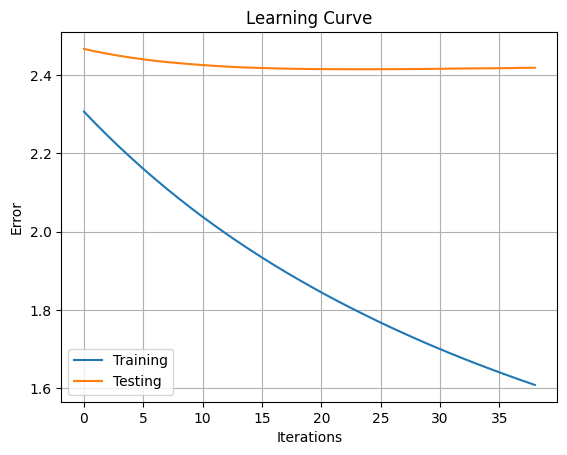

In [8]:
# Plot the learning curves
train_errors = evals_result['train']['MRRMSE']
val_errors = evals_result['eval']['MRRMSE']
plt.plot(train_errors, label='Training')
plt.plot(val_errors, label='Testing')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend()
plt.title('Learning Curve')
plt.grid(True)
plt.show()